While studying machine learning theory over the past year or so, I came across an interesting theorem that really sparked my interest. The [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that any feed forward neural network with a *single* hidden layer containing a finite number of units/neurons can fit any function. More specifically, we can attain any desired non-zero amount of error. In order words, we will always be able to output a prediction $ g(x) $ where $ |g(x) - f(x)| < \epsilon $ for all values of x. $ f(x) $ is the label and $ \epsilon $ is a very small positive non-zero number. When I read that for the first time, I almost did a double take because I was so surprised that something like that could be true. 

Let's think about what it really means. It's basically saying that if, for example, you're given a set of $ n $ training examples $ X $ where each $ x_i \in X $ is some $ k $-dimensional vector and you have a set of $ n $ training labels $ Y $ where each $ y_i \in Y $ is a label from the set {0,1} (binary classification), then you will be able to generate a neural network (with one hidden layer) that is able be trained to classify every single one of those $ n $ examples correctly. 

That was ridiculously interesting to me when I first saw it. 

And it made me think "Well, if this theorem is true, shouldn't neural networks be perfect at pretty much any task?". The key here, though, is that we encounter a **generalization** and **overfitting** problem when we try to fit a neural net too tightly to a particular training set, and expect the same results on the testing set. 

So, let's say that I want to create a neural network, with one hidden layer, that correctly classifies every example in the MNIST dataset. As you may recall, MNIST has about 55,000 images and is a 10 class classification problem. 

In [2]:
# The classic imports
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Load in the MNIST data and visualize the dimensions
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# oneImage is a tuple where oneImage[0] is the image and oneImage[1] is the one-hot label
oneImage = mnist.train.next_batch(1)
print ('Shape of the input: ' + str(oneImage[0].shape))
print ('Shape of the label: ' + str(oneImage[1].shape))
print ('Number of total images: ' + str(mnist.train.images.shape[0]))
numInputDimensions = oneImage[0].shape[1]
totalNumTrainImages = mnist.train.images.shape[0]
totalNumTestImages = mnist.test.images.shape[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of the input: (1, 784)
Shape of the label: (1, 10)
Number of total images: 55000


So now, let's just create a simple neural network with one hidden layer. This is what the architecture will look like. 

![alt text](Data/FunctionApproximation.png)

One of the big caveats with this theorem is that although it states that a one hidden layer neural network can approximate any function, it doesn't specify how many hidden units will be necessary to attain that 100% classification accuracy. When we think about the task of MNIST digit classification, the inputs will have 784 input features. Let's see what happens if we have a neural net with just 25 hidden units.

In [61]:
numHiddenUnits = 25

Also have to define some other useful parameters.

In [70]:
numClasses = 10
trainingIterations = 500000
batchSize = 32

Now, let's just create our simple neural network. If you'd like to see a more in depth tutorial on that, go ahead and take a look at my other tutorial [here](https://github.com/adeshpande3/Tensorflow-Programs-and-Tutorials/blob/master/Simple%20Neural%20Networks.ipynb).

In [64]:
tf.reset_default_graph() # Just to make sure that we start with a new graph
X = tf.placeholder(tf.float32, shape = [None, numInputDimensions])
y = tf.placeholder(tf.float32, shape = [None, numClasses])

W1 = tf.Variable(tf.truncated_normal([numInputDimensions, numHiddenUnits], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1), [numHiddenUnits])
W2 = tf.Variable(tf.truncated_normal([numHiddenUnits, numClasses], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1), [numClasses])

hiddenLayerOutput = tf.matmul(X, W1) + B1
hiddenLayerOutput = tf.nn.relu(hiddenLayerOutput)
finalOutput = tf.matmul(hiddenLayerOutput, W2) + B2
finalOutput = tf.nn.relu(finalOutput)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = finalOutput))
opt = tf.train.GradientDescentOptimizer(learning_rate = .01).minimize(loss)

correctPrediction = tf.equal(tf.argmax(finalOutput,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correctPrediction, "float"))

This is just a quick helper function to test how our network is doing throughout the training. 

In [65]:
def testOnDataset(imageDataset, labelDataset, numImages, session):
    numCorrectClassifications = 0
    for i in range(numImages):
        image = imageDataset[i]
        image = np.reshape(image, (1, numInputDimensions))
        label = labelDataset[i]
        label = np.reshape(label, (1, numClasses))
        pred = session.run(correctPrediction, feed_dict={X: image, y: label})
        if pred[0] == True:
            numCorrectClassifications += 1
    return numCorrectClassifications

Now that we've defined the graph, let's start to train it the model. 

In [66]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Training the network
halfParamCorrect = []
for i in range(trainingIterations):
    batch = mnist.train.next_batch(batchSize)
    batchInput = batch[0]
    batchLabels = batch[1]
    _, trainingLoss = sess.run([opt, loss], feed_dict={X: batchInput, y: batchLabels})
    if i%20000 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={X: batchInput, y: batchLabels})
        print ("step %d, training accuracy %g"%(i, trainAccuracy))
        numCorrect = testOnDataset(mnist.train.images, mnist.train.labels, totalNumTrainImages, sess)
        halfParamCorrect.append(numCorrect)

# Testing network on training set
numCorrectClassifications = testOnDataset(mnist.train.images, mnist.train.labels, totalNumTrainImages, sess)
print ("Number of digits (in training set) classified correctly: %d/%d"%(numCorrectClassifications, totalNumTrainImages))

# Testing network on test set
numCorrectClassifications = testOnDataset(mnist.test.images, mnist.test.labels, totalNumTestImages, sess)
print ("Number of digits (in test set) classified correctly: %d/%d"%(numCorrectClassifications, totalNumTestImages))

step 0, training accuracy 0.15625
step 20000, training accuracy 0.9375
step 40000, training accuracy 0.9375
step 60000, training accuracy 0.96875
step 80000, training accuracy 1
step 100000, training accuracy 0.9375
step 120000, training accuracy 0.9375
step 140000, training accuracy 0.96875
step 160000, training accuracy 0.96875
step 180000, training accuracy 0.96875
step 200000, training accuracy 0.96875
step 220000, training accuracy 1
step 240000, training accuracy 1
step 260000, training accuracy 1
step 280000, training accuracy 1
step 300000, training accuracy 1
step 320000, training accuracy 1
step 340000, training accuracy 0.96875
step 360000, training accuracy 1
step 380000, training accuracy 1
Number of digits (in training set) classified correctly: 54571/55000
Number of digits (in test set) classified correctly: 9652/10000


So, as you can see, the network was able to reach a decent accuracy, but it still isn't classifying every example in our training set correctly. Now, let's see what happens when we bump up the number of hidden units by a **lot** and create the graph again. 

In [71]:
numHiddenUnits = 2000 

In [72]:
tf.reset_default_graph() # Just to make sure that we start with a new graph
X = tf.placeholder(tf.float32, shape = [None, numInputDimensions])
y = tf.placeholder(tf.float32, shape = [None, numClasses])

W1 = tf.Variable(tf.truncated_normal([numInputDimensions, numHiddenUnits], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1), [numHiddenUnits])
W2 = tf.Variable(tf.truncated_normal([numHiddenUnits, numClasses], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1), [numClasses])

hiddenLayerOutput = tf.matmul(X, W1) + B1
hiddenLayerOutput = tf.nn.relu(hiddenLayerOutput)
finalOutput = tf.matmul(hiddenLayerOutput, W2) + B2
finalOutput = tf.nn.relu(finalOutput)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = finalOutput))
opt = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)

correctPrediction = tf.equal(tf.argmax(finalOutput,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correctPrediction, "float"))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

doubleParamCorrect = []
for i in range(trainingIterations):
    batch = mnist.train.next_batch(batchSize)
    batchInput = batch[0]
    batchLabels = batch[1]
    _, trainingLoss = sess.run([opt, loss], feed_dict={X: batchInput, y: batchLabels})
    if i%10000 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={X: batchInput, y: batchLabels})
        print ("step %d, training accuracy %g"%(i, trainAccuracy))
        numCorrect = testOnDataset(mnist.train.images, mnist.train.labels, totalNumTrainImages, sess)
        doubleParamCorrect.append(numCorrect)
        
# Testing network on training set
numCorrectClassifications = testOnDataset(mnist.train.images, mnist.train.labels, totalNumTrainImages, sess)
print ("Number of digits (in training set) classified correctly: %d/%d"%(numCorrectClassifications, totalNumTrainImages))

# Testing network on test set
numCorrectClassifications = testOnDataset(mnist.test.images, mnist.test.labels, totalNumTestImages, sess)
print ("Number of digits (in test set) classified correctly: %d/%d"%(numCorrectClassifications, totalNumTestImages))

step 0, training accuracy 0.25
step 10000, training accuracy 1
step 20000, training accuracy 1
step 30000, training accuracy 1
step 40000, training accuracy 1
step 50000, training accuracy 1
step 60000, training accuracy 1
step 70000, training accuracy 1
step 80000, training accuracy 1
step 90000, training accuracy 1
step 100000, training accuracy 1
step 110000, training accuracy 1
step 120000, training accuracy 1
step 130000, training accuracy 1
step 140000, training accuracy 1
step 150000, training accuracy 1
step 160000, training accuracy 1
step 170000, training accuracy 1
step 180000, training accuracy 1
step 190000, training accuracy 1
step 200000, training accuracy 1
step 210000, training accuracy 1
step 220000, training accuracy 1
step 230000, training accuracy 1
step 240000, training accuracy 1
step 250000, training accuracy 1
step 260000, training accuracy 1
step 270000, training accuracy 1
step 280000, training accuracy 1
step 290000, training accuracy 1
step 300000, training

Ah, we're reached 100% classification accuracy! This does back up the theorem that any dataset (like MNIST) can be fully fit with a single hidden layer neural network, **provided that we have a sufficiently large number of hidden units**. As you saw with the two runs of the neural networks, the first run showed that the number of hidden units wasn't large enough as we weren't able to fully fit the function. When we increased the number of hidden units, the training set accuracy got to 100%. However, the crux of this topic lies in the problem that the test accuracy of the smaller network actually turned out to be greater than the accuracy of the larger network that was able to fully fit to the dataset. This is the classic machine learning problem of **overfitting**. 

Here's a final look at the classification accuracies as the number of training iterations increases. 

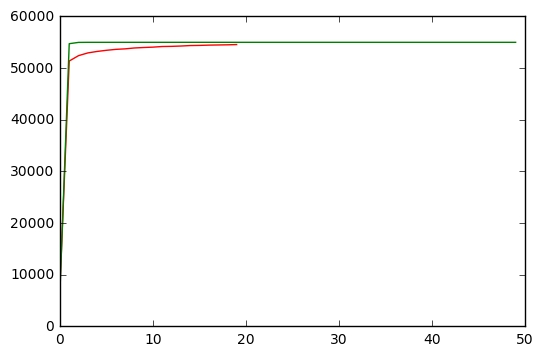

In [73]:
plt.plot(halfParamCorrect, 'r')
plt.plot(doubleParamCorrect, 'g')
plt.show()

So, what's the moral of the story? Yes, a neural network can fit any dataset and can approximate any function, but the question is **"Should you allow it to?"**. When a neural network gets so fit to a particular training dataset, it isn't able to properly generalize, and that's when the test accuracy (which really is the most important metric in an ML system) drops. Our particular network got so fit to the training set because our model complexity was too high in that we had an extremely large number of hidden units. This was necessary to get the 100% classification accuracy on the train set, but hurt our ability to do well on the test set. The key in a lot of machine learning models is to find that crucial balance between having a network that is complex enough to fit the training data, and simple enough to be able to generalize to examples it hasn't seen before. 

More Reading:
- [Visual proof](http://neuralnetworksanddeeplearning.com/chap4.html) of theorem
- [Mathematical perspective](http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html)
- [Cybenko's paper](https://link.springer.com/article/10.1007/BF02551274) and [Hornik's paper](http://www.sciencedirect.com/science/article/pii/0893608089900208) that proved the theorem